## Single Decision Maker (UNOS) Q-Learning

In [1]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, beta, expon

### Helper functions

In [2]:
# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }
# Ensure state exists in Q-table
def initialize_state_in_q_table(group_Q_tables, group_id, state):

    if state not in group_Q_tables[group_id]:
        group_Q_tables[group_id][state] = [0] * 11  # Initialize all actions with Q-values of 0



### Transition functions

#### Steady Arrivals

In [3]:
def decentralized_transition(state, actions, sample_urgency_func, patients_per_group):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups

    # Allocate organs and calculate group rewards
    for group_id, priority in enumerate(actions):
        matched_organs = 0
        for _ in range(patients_per_group[group_id + 1]):  # Iterate over patients in the group
            if new_state["organs"] <= 0:  # Stop if no organs are left
                break
            urgency = sample_urgency_func(group_id)
            if urgency > priority:  # Check if urgency justifies allocation
                matched_organs += 1
                new_state["organs"] -= 1  # Decrement shared organ pool

        new_state["patient_groups"].append({"matched_organs": matched_organs})
        rewards[group_id] = matched_organs * priority  # Reward for matching organs

    # Add penalty for ignoring high-priority patients
    organs_not_alloc_to_high = (
        patients_per_group[3] - new_state["patient_groups"][2]["matched_organs"]
    )  # Group 3: high priority
    organs_alloc_to_low_med = (
        new_state["patient_groups"][0]["matched_organs"]  # Low-priority group
        + new_state["patient_groups"][1]["matched_organs"]  # Medium-priority group
    )
    if organs_not_alloc_to_high > 0 and organs_alloc_to_low_med > 0:
        penalty = organs_not_alloc_to_high * 2  # Apply penalty
        for group_id in range(num_groups):
            # Distribute penalty equally across low- and medium-priority groups
            if group_id in [0, 1]:  # Low and medium-priority groups
                rewards[group_id] -= penalty  # Split penalty

    new_state["organs"] = max(0, new_state["organs"])  # Ensure non-negative organ count
    return new_state, rewards, patients_per_group


#### Randomized Arrivals

In [4]:
def decentralized_transition_add(state, actions, sample_urgency_func, old_patients_per_group):
    patients_per_group = old_patients_per_group.copy()
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups

    # Allocate organs and calculate group rewards
    for group_id, priority in enumerate(actions):
        matched_organs = 0

        # Iterate over patients currently in the group
        for _ in range(patients_per_group[group_id + 1]):
            if new_state["organs"] <= 0:  # Stop if no organs are left
                break
            urgency = sample_urgency_func(group_id)
            if urgency > priority:  # Check if urgency justifies allocation
                matched_organs += 1
                new_state["organs"] -= 1  # Decrement shared organ pool

        # Add new patients to the group based on Poisson arrivals
        new_patients = np.random.poisson(group_lambdas[group_id])
        patients_per_group[group_id + 1] += new_patients

        # Update patient group size after matching
        patients_per_group[group_id + 1] -= matched_organs
        new_state["patient_groups"].append({"matched_organs": matched_organs})

        # Reward for matched organs
        rewards[group_id] = matched_organs * priority

    # Add penalty for ignoring high-priority patients
    organs_not_alloc_to_high = (
        old_patients_per_group[3] - new_state["patient_groups"][2]["matched_organs"]
    )  # Group 3: high priority
    organs_alloc_to_low_med = (
        new_state["patient_groups"][0]["matched_organs"]  # Low-priority group
        + new_state["patient_groups"][1]["matched_organs"]  # Medium-priority group
    )
    if organs_not_alloc_to_high > 0 and organs_alloc_to_low_med > 0:
        penalty = organs_not_alloc_to_high * 2  # Apply penalty
        for group_id in range(num_groups):
            # Distribute penalty equally across low- and medium-priority groups
            if group_id in [0, 1]:  # Low and medium-priority groups
                rewards[group_id] -= penalty  # Split penalty

    # Ensure organs count is non-negative
    new_state["organs"] = max(0, new_state["organs"])

    return new_state, rewards, patients_per_group


### Sampling distributions

In [5]:
# Define urgency sampling function
def sample_urgency_beta(group_id):
    #Beta params
    alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
    beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

In [6]:
# Sample urgency using Meld
# Define urgency sampling function
from scipy.stats import norm, beta, expon

# Define distribution parameters for each group
low_risk_params = {'mean': 7.6, 'std': 1.056} #Normal
med_risk_params = {'a': 0.916, 'b': 1.562, 'loc': 10.0, 'scale': 29.609} #Beta
high_risk_params = {'loc': 40.0, 'scale': 3.408} #exp

# Theoretical ranges based on MELD scores
low_risk_range = (norm.ppf(0.01, loc=low_risk_params['mean'], scale=low_risk_params['std']),
                  norm.ppf(0.99, loc=low_risk_params['mean'], scale=low_risk_params['std']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency_meld(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=3)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=7, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]

### Extract optimal policy

In [7]:
# Extract optimal policy
def extract_optimal_policy_Nash(Q_table):
    optimal_policy = {}
    for state, actions in Q_table.items():
        optimal_action = np.argmax(actions)
        optimal_policy[state] = optimal_action
    return optimal_policy


# Simulate with optimal policy
def simulate_with_optimal_policy(optimal_policies, initialize_state, transition_func, sample_func, patients_per_group):
    state = initialize_state()
    organs_allocated_over_time = []
    group_allocations = {group_id: [] for group_id in range(len(optimal_policies))}

    for t in range(time_horizon):
        if state['organs'] <= 0:
            break

        actions = []
        for group_id, optimal_policy in enumerate(optimal_policies):
            key = (state["time"], state["organs"])
            if key in optimal_policy:
                actions.append(optimal_policy[key])
            else:
                print("using random action")
                actions.append(random.choice(range(11)))

        next_state, _, patients_per_group = transition_func(state, actions, sample_func, patients_per_group)
        cumulative_allocations = total_organs - next_state["organs"]
        organs_allocated_over_time.append(cumulative_allocations)

        for group_id, group_info in enumerate(next_state["patient_groups"]):
            group_allocations[group_id].append(group_info["matched_organs"])

        state = next_state

    return organs_allocated_over_time, group_allocations

### Q-learning loop

In [8]:
def Nash_Q_learn(transition_func, sample_func, patients_per_group, num_episodes, alpha, gamma, epsilon): 
    # Initialize Q-tables for each group
    group_Q_tables = [
        {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
        for _ in range(num_groups)
    ]

    # Q-learning loop
    group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}

    for episode in range(num_episodes):
        state = initialize_state()
        total_rewards = [0] * num_groups

        for t in range(time_horizon):
            if state["organs"] <= 0:
                break

            # Compute Nash equilibrium actions
            actions = []
            for group_id in range(num_groups):
                group_state = (state["time"], state["organs"])
                if random.uniform(0, 1) < epsilon:
                    actions.append(random.randint(0, 10))  # Explore
                else:
                    actions.append(np.argmax(group_Q_tables[group_id][group_state]))  # Exploit

            # Perform decentralized transition
            next_state, rewards, patients_per_group = transition_func(state, actions, sample_func, patients_per_group)

            # Update Q-tables
            for group_id in range(num_groups):
                group_state = (state["time"], state["organs"])
                next_group_state = (next_state["time"], next_state["organs"])
                initialize_state_in_q_table(group_Q_tables, group_id, group_state)
                initialize_state_in_q_table(group_Q_tables, group_id, next_group_state)
                best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
                q_update = rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
                group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                    q_update - group_Q_tables[group_id][group_state][actions[group_id]]
                )

            state = next_state
            total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

        for group_id in range(num_groups):
            group_rewards_per_episode[group_id].append(total_rewards[group_id])

        epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon
    return group_Q_tables, group_rewards_per_episode


### Plots

In [9]:
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']

def plot_cumulative(group_rewards_per_episode, title):
    # Plot cumulative rewards per episode
    plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
    plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
    for group_id in range(num_groups):
        plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
    plt.title("Cumulative Rewards per Episode for Each Group")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.legend(title="Group", loc="upper left")
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    plt.savefig(f"{title}.png")
    plt.show()

def plot_average(group_rewards_per_episode, title):
    window = 20  # Moving average window
    avg_rewards = [ [
        np.mean(group_rewards_per_episode[group_id][i : i + window])
        for i in range(len(group_rewards_per_episode[group_id]) - window)
    ] for group_id in range(num_groups)]

    # Plot cumulative rewards per episode
    labels = ['Low Risk', 'Medium Risk', 'High Risk']
    colors = ['green', 'orange', 'red']
    plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
    for group_id in range(num_groups):
        plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
    plt.title("Average Rewards per Episode for Each Group")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend(title="Group", loc="upper left")
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    plt.savefig(f"{title}.png")
    plt.show()

def plot_organs_allocated(group_Q_tables, transition_func, sample_func, title, patients_per_group):
    # Simulate and plot results
    optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]
    organs_allocated_over_time, group_allocations = simulate_with_optimal_policy(
        optimal_policies, initialize_state, transition_func, sample_func, patients_per_group
    )

    plt.plot(organs_allocated_over_time, label="Total Allocations")
    for group_id, allocations in group_allocations.items():
        plt.plot(np.cumsum(allocations), label=labels[group_id], color = colors[group_id])
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)


    # Format the plot
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')

    plt.xlim(0)
    plt.ylim(0)
    plt.title("Organs Allocated Over Time for Each Group")
    plt.xlabel("Time Steps")
    plt.ylabel("Total Organs Allocated")
    plt.legend(title="Group", loc="upper left")
    
    plt.savefig(f"{title}.png")

    plt.show()
    
    
def plot_single_heatmap(data_dict, title):
    # Convert dictionary to DataFrame
    df = pd.DataFrame(
        list(data_dict.items()), 
        columns=['Time_Organ', 'Action']
    )
    df[['Time', 'Organ']] = pd.DataFrame(df['Time_Organ'].tolist(), index=df.index)
    df = df.drop(columns=['Time_Organ'])
    
    # Pivot data for heatmap
    heatmap_data = df.pivot(index='Organ', columns='Time', values='Action')
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    plt.imshow(heatmap_data, aspect='auto', cmap='viridis')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Organs')
    plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
    plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
    plt.colorbar(label='Actions')
    plt.tight_layout()
    plt.show()


In [10]:
def normalize_and_scale_rewards_per_group(rewards):
    normalized_rewards = {}
    for group_id, group_rewards in rewards.items():
        min_reward = min(group_rewards)
        max_reward = max(group_rewards)
        normalized_rewards[group_id] = [
            100 * (reward - min_reward) / (max_reward - min_reward)
            if max_reward > min_reward else 0  # Avoid division by zero
            for reward in group_rewards
        ]
    return normalized_rewards

def plot_cumulative(group_rewards_per_episode, title):
    # Normalize and scale rewards per group
    group_rewards_per_episode = normalize_and_scale_rewards_per_group(group_rewards_per_episode)

    # Plot cumulative rewards per episode
    plt.plot(
        [sum(values) for values in zip(*group_rewards_per_episode.values())],
        label="Total over Groups",
    )
    plt.grid(axis="y", color="lightgray", linestyle="-", linewidth=0.5, alpha=0.6)
    for group_id in range(num_groups):
        plt.plot(
            group_rewards_per_episode[group_id],
            label=labels[group_id],
            color=colors[group_id],
        )
    plt.title("Scaled Cumulative per Episode for Each Group")
    plt.xlabel("Episode")
    plt.ylabel("Scaled Reward")
    plt.legend(title="Group", loc="upper left")
    ax = plt.gca()
    ax.spines["top"].set_color("gray")
    ax.spines["bottom"].set_color("gray")
    ax.spines["left"].set_color("gray")
    plt.savefig(f"{title}.png")
    plt.show()

def plot_average(group_rewards_per_episode, title):
    # Normalize and scale rewards per group
    group_rewards_per_episode = normalize_and_scale_rewards_per_group(group_rewards_per_episode)

    window = 20  # Moving average window
    avg_rewards = [
        [
            np.mean(group_rewards_per_episode[group_id][i : i + window])
            for i in range(len(group_rewards_per_episode[group_id]) - window)
        ]
        for group_id in range(num_groups)
    ]

    # Plot average rewards per episode
    plt.grid(axis="y", color="lightgray", linestyle="-", linewidth=0.5, alpha=0.6)
    for group_id in range(num_groups):
        plt.plot(
            avg_rewards[group_id],
            label=labels[group_id],
            color=colors[group_id],
        )
    plt.title("Average Rewards per Episode for Each Group")
    plt.xlabel("Episode")
    plt.ylabel("Scaled Average Reward")
    plt.legend(title="Group", loc="upper left")
    ax = plt.gca()
    ax.spines["top"].set_color("gray")
    ax.spines["bottom"].set_color("gray")
    ax.spines["left"].set_color("gray")
    ax.spines["right"].set_color("gray")
    plt.savefig(f"{title}.png")
    plt.show()


In [11]:
def simulate_optimal_policy_and_track(optimal_policies, total_organs, time_horizon, initialize_state, transition_func,
                                     sample_frequency_func):
    state = initialize_state()
    patients_per_group = {1: 2, 2: 5, 3: 1}
    results = {group_id: {"allocations": [], "group_sizes": []} for group_id in range(num_groups)}

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute actions based on optimal policy
        actions = []
        for group_id, optimal_policy in enumerate(optimal_policies):
            group_state = (state["time"], state["organs"])
            if group_state in optimal_policy:
                actions.append(optimal_policy[group_state])
            else:
                actions.append(0)  # Default action if state not in policy

        # Perform the transition
        next_state, _ , patients_per_group = transition_func(state, actions, sample_frequency_func, patients_per_group)

        # Track allocations and group sizes for each group
        for group_id, group_info in enumerate(next_state["patient_groups"]):
            allocations = group_info["matched_organs"]
            group_size = patients_per_group[group_id + 1]
            results[group_id]["allocations"].append(allocations)
            results[group_id]["group_sizes"].append(group_size)

        state = next_state

    return results

# Plot results
def plot_demand_allocation(results, title):
    labels = ['Low', 'Med', 'High']
    colors = ['green', 'orange', 'red']

    for group_id in range(num_groups):
        # Plot allocations
        plt.plot(
            range(len(results[group_id]["allocations"])),
            results[group_id]["allocations"],
            label=f"Allocations ({labels[group_id]})",
            linestyle="--",
            color=colors[group_id]
        )

        # Plot group sizes
        plt.plot(
            range(len(results[group_id]["group_sizes"])),
            results[group_id]["group_sizes"],
            label=f"Group Size ({labels[group_id]})",
            color=colors[group_id]
        )

    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')

    plt.title("Optimal Policy Allocations vs Group Sizes Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Count")
    #plt.legend(title="Legend", loc="upper left")
    plt.legend(title="Legend", loc="upper left", bbox_to_anchor=(1.05, 1.0))
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
    plt.savefig(f"{title}.png")
    plt.show()


### Steady Patient Arrivals

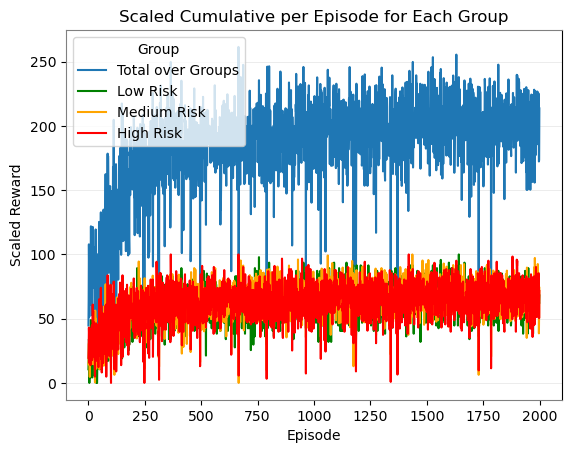

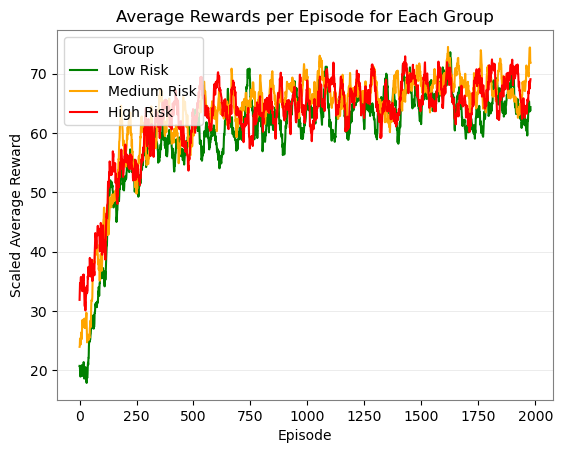

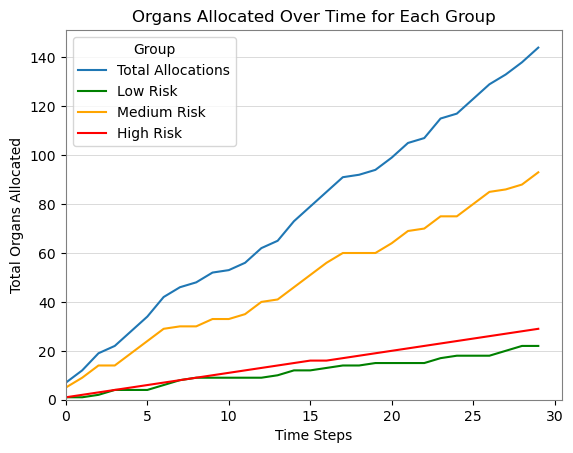

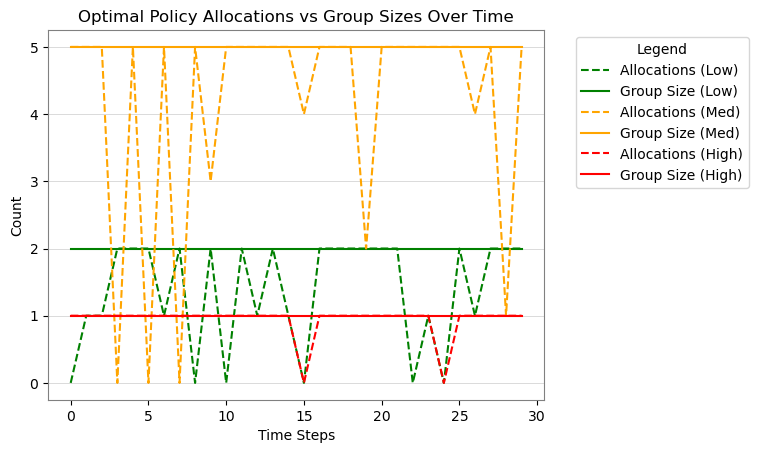

In [12]:
# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 2000  # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3: 1}
group_lambdas = [2, 5, 1]  # Mean number of new patients for each group

epsilon = 0.8
alpha = 0.3
gamma = 0.99

transition_func = decentralized_transition
sample_func = sample_urgency_meld




group_Q_tables, group_rewards_per_episode = Nash_Q_learn(transition_func, sample_func, patients_per_group, num_episodes, alpha, gamma, epsilon)
optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]
patients_per_group = {1: 2, 2: 5, 3: 1}
organs_allocated_over_time, group_allocations = simulate_with_optimal_policy(
        optimal_policies, initialize_state, transition_func, sample_func, patients_per_group
    )

plot_cumulative(group_rewards_per_episode, "nash_q_steady_arrivals_cumulative")
plot_average(group_rewards_per_episode, "nash_q_steady_arrivals_average")
patients_per_group = {1: 2, 2: 5, 3: 1}
plot_organs_allocated(group_Q_tables, transition_func, sample_func, "nash_q_steady_arrivals_org_alloc", patients_per_group)

# Extract optimal policies for each group
optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]

# Simulate and track results
results = simulate_optimal_policy_and_track(
    optimal_policies, total_organs, time_horizon, initialize_state, transition_func, sample_func
)
plot_demand_allocation(results, "nash_q_steady_arrivals_demand_alloc")

## Randomized Patient Arrivals Results

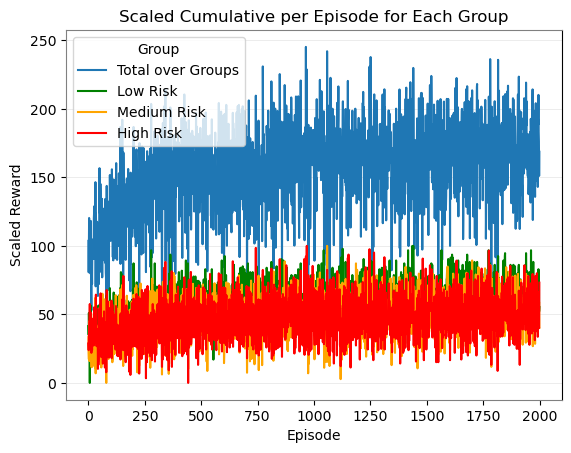

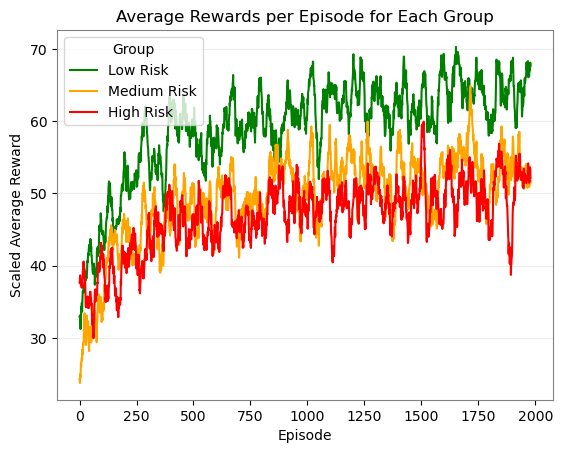

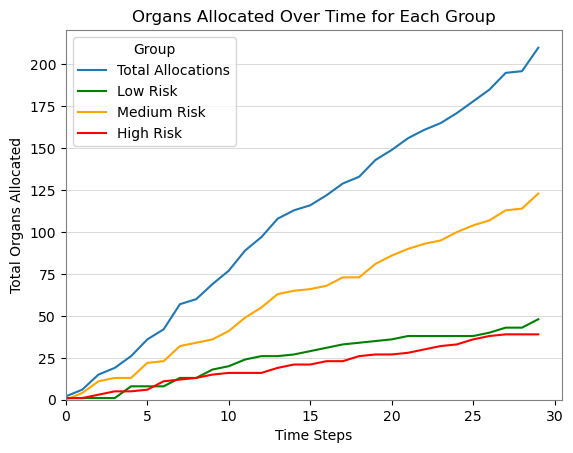

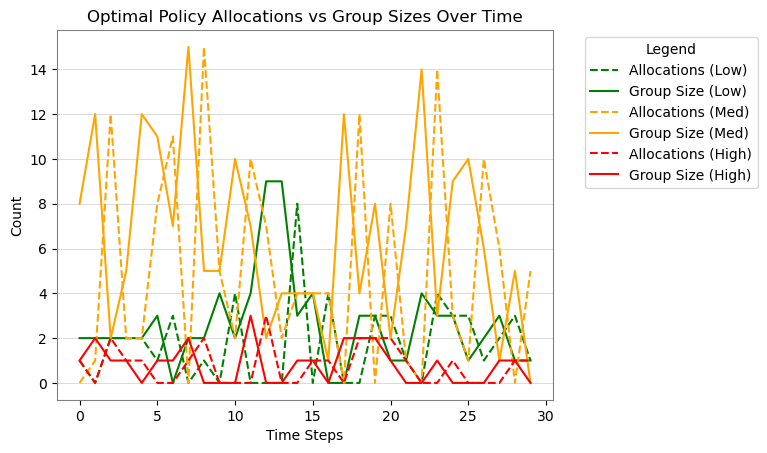

In [13]:
# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 2000  # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3: 1}
group_lambdas = [2, 5, 1]  # Mean number of new patients for each group

epsilon = 0.8
alpha = 0.3
gamma = 0.99

transition_func = decentralized_transition_add
sample_func = sample_urgency_meld




group_Q_tables, group_rewards_per_episode = Nash_Q_learn(transition_func, sample_func, patients_per_group, num_episodes, alpha, gamma, epsilon)
optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]
patients_per_group = {1: 2, 2: 5, 3: 1}
organs_allocated_over_time, group_allocations = simulate_with_optimal_policy(
        optimal_policies, initialize_state, transition_func, sample_func, patients_per_group
    )

plot_cumulative(group_rewards_per_episode, "nash_q_random_arrivals_cumulative")
plot_average(group_rewards_per_episode, "nash_q_random_arrivals_average")
patients_per_group = {1: 2, 2: 5, 3: 1}
plot_organs_allocated(group_Q_tables, transition_func, sample_func, "nash_q_random_arrivals_org_alloc", patients_per_group)

# Extract optimal policies for each group
optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]

# Simulate and track results
results = simulate_optimal_policy_and_track(
    optimal_policies, total_organs, time_horizon, initialize_state, transition_func, sample_func
)
plot_demand_allocation(results, "nash_q_random_arrivals_demand_alloc")

## Average Reward for last 200 iterations over 10 runs

In [ ]:
avg_rewards_per_group_over_runs = {group_id: [] for group_id in range(3)}  # Initialize for each group

for i in range(10):
    print(f"Calc iter: {i+1}")
    # Parameters
    num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
    total_organs = 500  # Initial organ supply
    time_horizon = 30  # Ischemic time limit (discrete time steps)
    num_episodes = 2000  # Number of Q-learning episodes

    patients_per_group = {1: 2, 2: 5, 3: 1}
    group_lambdas = [2, 5, 1]

    # Parameters for when people get added
    epsilon = 0.8
    alpha = 0.3
    gamma = 0.99  # This absolutely needs to be 1

    transition_func = decentralized_transition_add
    sample_func = sample_urgency_meld

    group_Q_tables, group_rewards_per_episode = Nash_Q_learn(transition_func, sample_func, patients_per_group, num_episodes, alpha, gamma, epsilon)
    # Normalize rewards per group
    normalized_rewards_per_group = normalize_and_scale_rewards_per_group(group_rewards_per_episode)

    # Calculate average normalized rewards over the last 200 episodes for each group
    for group_id, normalized_rewards in normalized_rewards_per_group.items():
        avg_reward = np.mean(normalized_rewards[-200:])
        avg_rewards_per_group_over_runs[group_id].append(avg_reward)

# Calculate overall average normalized rewards for each group across all runs
overall_avg_rewards_per_group = {group_id: np.mean(avg_rewards) for group_id, avg_rewards in avg_rewards_per_group_over_runs.items()}

print("Average rewards per group over runs:")
print(avg_rewards_per_group_over_runs)
print("Overall average rewards per group:")
print(overall_avg_rewards_per_group)
